In [1]:
import tensorflow as tf
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(50,30)

In [4]:
filepath = "h5s/railway_2_d12e-2.hdf5"

In [5]:
model = tf.keras.models.load_model(filepath)

In [6]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 60, 200, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 60, 200, 32)  896         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 58, 198, 32)  9248        conv2d_24[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 58, 198, 32)  128         conv2d_25[0][0]                  
____________________________________________________________________________________________

In [7]:
#no crop function
def parse_label(strIN):
    return (strIN==CLASS_NAMES).astype(float)
def readimg_to_tensor(fn):
    a = tf.io.read_file((fn))
    img = tf.io.decode_jpeg(a)
    return img


In [8]:

CLASS_NAMES = np.array([])
for i in range(10):
    CLASS_NAMES =np.append(CLASS_NAMES,chr(ord("0")+i))
for i in range(26):
    CLASS_NAMES = np.append(CLASS_NAMES,chr(ord("A")+i))

In [9]:
def parseResult(RS):
    for j in range(len(RS[0])):
        PredChr=''
        for i in range(6):
            PredChr+= CLASS_NAMES[(np.where(RS[i][j] == RS[i][j].max())[0][0])]
        if j == 0:
            LB = [PredChr]
        else:
            LB.append(PredChr)      
    return LB
     

In [10]:
#01
val_dir_data = os.path.abspath(os.getcwd())+"\\dev\\data01_dev"
#validation data no crop
val_dir = tf.data.Dataset.list_files(val_dir_data+'*.jpg',shuffle=False) 
val_data = val_dir.map(lambda x: readimg_to_tensor(x))


In [10]:
img = next(iter(val_data.batch(10000)))

In [11]:
#output to CSV
VDlabel = np.array([])
img = next(iter(val_data.batch(10000)))
result = model.predict(img,use_multiprocessing = True)
test = parseResult(result)
val_file_name = pd.read_csv("./dev/data01_dev.csv")
val_file_name.join(pd.DataFrame(test,columns=["code"])).to_csv("data01_dev.csv",index = False) 

In [ ]:
#02
val_dir_data02 = os.path.abspath(os.getcwd())+"\\dev\\data02_dev"
#validation data no crop
val_dir = tf.data.Dataset.list_files(val_dir_data02+'*.jpg',shuffle=False) 
val_data02 = val_dir.map(lambda x: readimg_to_tensor(x))
#output to CSV
VDlabel = np.array([])
img = next(iter(val_data02.batch(10000)))
result = model.predict(img,use_multiprocessing = True)
val_dir = tf.data.Dataset.list_files(val_dir_data02+'*.jpg',shuffle=False) 
test = parseResult(result)
val_file_name = pd.read_csv("./dev/data02_dev.csv")
val_file_name.join(pd.DataFrame(test,columns=["code"])).to_csv("data02_dev.csv",index = False) 

In [12]:
import tensorflow.keras.models as models

In [13]:
#visualize
def show_model_vision(model,img):
    
    img_tensor = tf.expand_dims(img[np.random.randint(10000)],0)
    result = model(img_tensor)
    PredChr=''
    for i in range(6):
        PredChr+= (
            CLASS_NAMES[
            np.where(result[i].numpy()[0] == result[i].numpy()[0].max())[0][0]
            ])
    
    print("Predict character: "+ PredChr)
    # Extracts the outputs of the top 8 layers:
    layer_outputs = [layer.output for layer in model.layers[:] if hasattr(layer,"kernel_size") and getattr(layer,"kernel_size")==(3,3)]
    # Creates a model that will return these outputs, given the model input:
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    # one array per layer activation
    activations = activation_model.predict(img_tensor)
    
    # These are the names of the layers, so can have them as part of our plot
    layer_names = []
    for layer in model.layers[:]:
        if hasattr(layer,"kernel_size") and getattr(layer,"kernel_size")==(3,3):
            layer_names.append(layer.name) 

    images_per_row = 3
    # Now let's display our feature maps
    k=1
    for layer_name, layer_activation in zip(layer_names, activations):
        for n in range(images_per_row):
            ax = plt.subplot(len(layer_names),images_per_row,k)
            plt.imshow(layer_activation[0, :, :,np.random.randint(layer_activation.shape[-1]) ], cmap='viridis')
            plt.title(layer_name)
            plt.axis('image')
            plt.tight_layout()
            k+=1
    plt.show()

In [14]:
plt.rcParams['figure.figsize']=(30,30)

Predict character: UO3H47


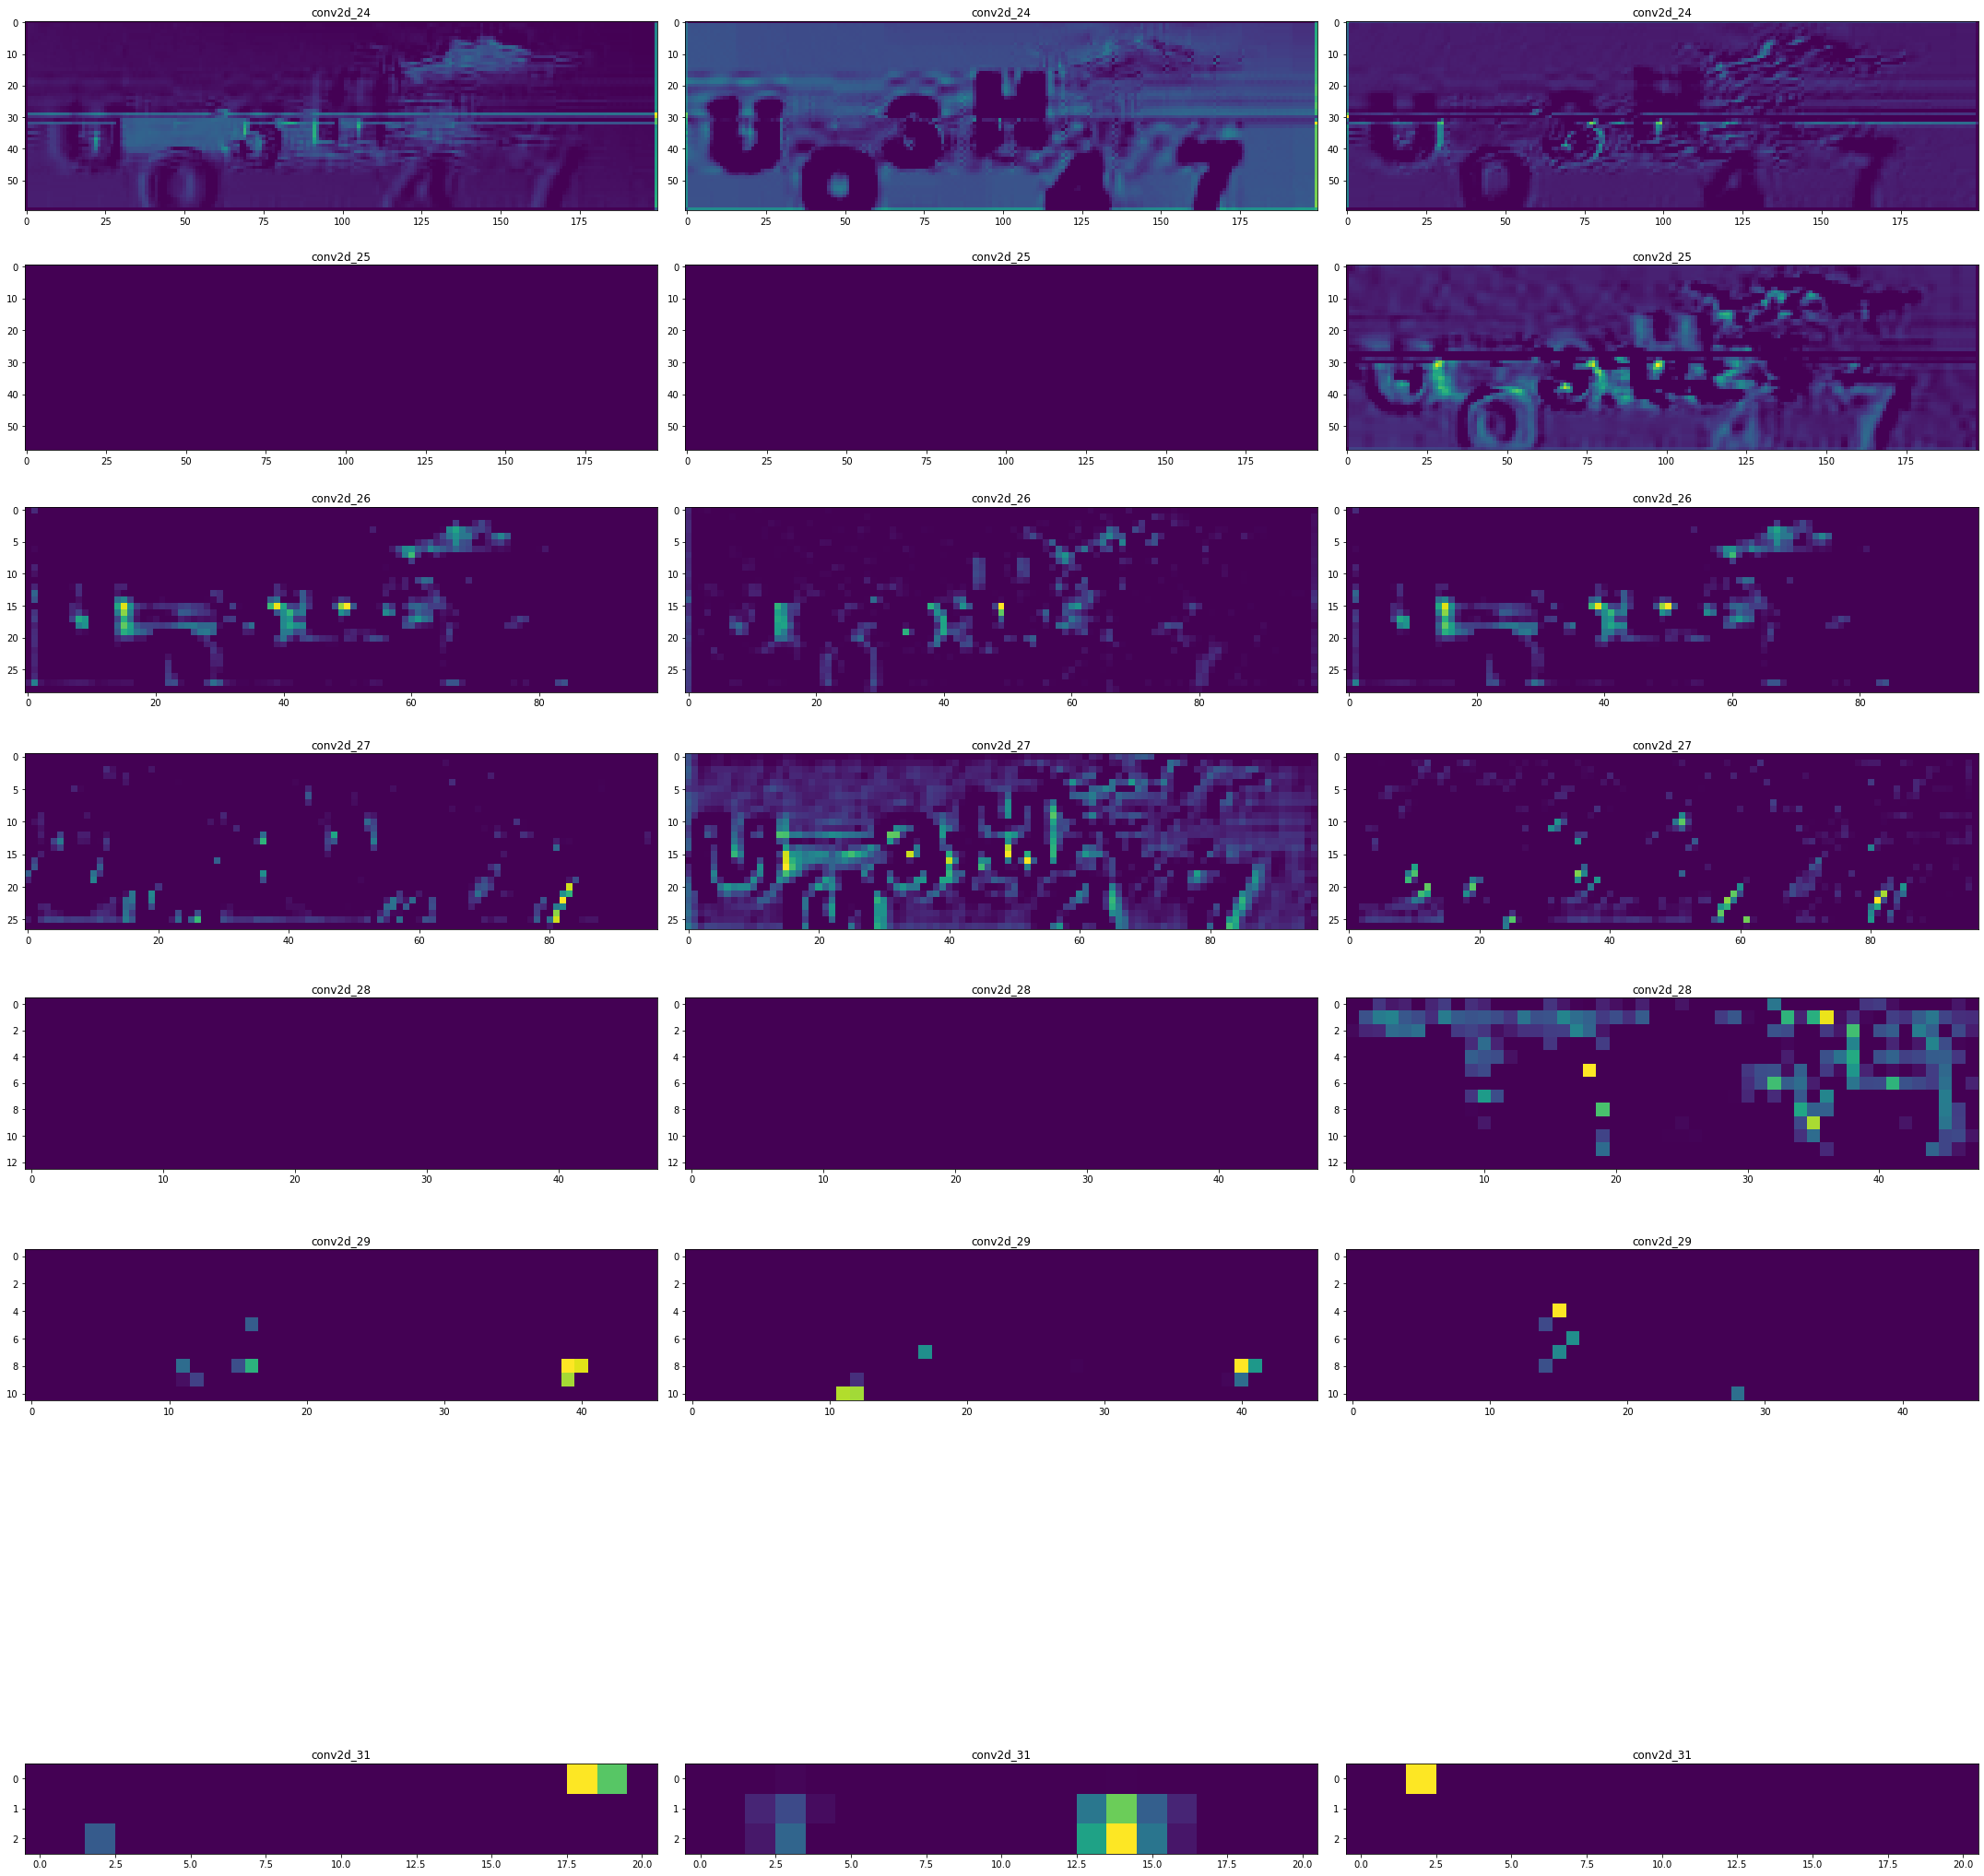

In [15]:
show_model_vision(model,img)

# 紀錄

## data 01

Raiway_ini_and_WR_L0.4383.hdf5  95.47%

ResNet_small_4_mixSGD_.40.hdf5  93.74%

ResNet_small_4_mixSGD_.57587.hdf5 92.87%

ResNet_small_4_mixSGD_.4219.hdf5 92.68%

railway_2_wr1e-3.hdf5 97.24%

railway_2_wr_5e-3.hdf5 97.72%

railway_2_d12e-2.hdf5 97.53%

## data 02